---
## <span style="color:orange"> Host Multiple TensorFlow Computer Vision Models using SageMaker Multi-Model Endpoint </span>
---
## <span style="color:black">Contents</span>
1. [Background](#Background)
1. [Setup](#Setup)
1. [Train Model 1 - CIFAR-10 Image Classification](#Train-Model-1---CIFAR-10-Image-Classification)
1. [Train Model 2 - Sign Language Image Classification](#Train-Model-2---Sign-Language-Image-Classification)
1. [Create a Multi-Model Endpoint](#Create-a-Multi-Model-Endpoint)
1. [Test Multi-Model Endpoint for Real Time Inference](#Test-Multi-Model-Endpoint-for-Real-Time-Inference)

### Background
In this notebook, we show how to host two computer vision models trained using the TensorFlow framework under one SageMaker multi-model endpoint.  For the first model, we train a smaller version of AlexNet CNN to classify images from the CIFAR-10 dataset. For the second model, we use a pretrained VGG16 CNN model pretrained on the ImageNet dataset and fine-tune on Sign Language Digits Dataset.

### Setup

 #### Prerequisites 
 Choose Kernel for this notebook.<br>
 Under `Kernel` tab at the top of this notebook &#8594; `Choose kernel`, select `conda_python3` 

In [1]:
%%capture

!pip install tensorflow==2.3.0

#### Imports 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sagemaker.tensorflow.serving import TensorFlowModel
from sagemaker.multidatamodel import MultiDataModel
from tensorflow.keras.datasets import cifar10
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from tensorflow.keras import utils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import sagemaker
import logging
import boto3
import time
import os

2025-03-23 17:50:04.759496: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-23 17:50:04.764143: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-23 17:50:04.776415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742752204.798473    2957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742752204.804664    2957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 17:50:04.825874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Setup Logger

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [4]:
logger.info(f'[Using TensorFlow version: {tf.__version__}]')
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')

[Using TensorFlow version: 2.18.0]


[03/23/25 17:50:10] INFO     [Using TensorFlow version: 2.18.0]                                     ]8;id=945163;file:///tmp/ipykernel_2957/1269320223.py\1269320223.py]8;;\:]8;id=78021;file:///tmp/ipykernel_2957/1269320223.py#1\1]8;;\

[Using SageMaker version: 2.242.0]


                    INFO     [Using SageMaker version: 2.242.0]                                     ]8;id=167927;file:///tmp/ipykernel_2957/1269320223.py\1269320223.py]8;;\:]8;id=100982;file:///tmp/ipykernel_2957/1269320223.py#2\2]8;;\

#### Seed for Reproducability

In [5]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Create Roles, Sessions and Data Locations

In [6]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.3.0'
BUCKET = sagemaker.Session().default_bucket()
PREFIX = 'cv-models'

### Train Model 1 - CIFAR-10 Image Classification

<p align="justify">First, we will train a Convolutional Neural Network (CNN) model to classify images from the CIFAR-10 dataset. Image classification is the task of assigning a label to an image, from a predefined set of categories. CIFAR-10 is an established CV dataset used for object recognition. It is a subset of the 80 Million Tiny Images dataset and consists of 60,000 (32x32) color images containing 1 of 10 object classes, with 6,000 images per class.</p>

#### a) Load Data

The first step is to load the pre-shuffled CIFAR-10 dataset into our train and test objects. Luckily, Keras provides the CIFAR dataset for us to load using the `load_data()` method. All we have to do is import keras.datasets and then load the data.

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [8]:
logger.info(f'X_train Shape: {X_train.shape}')
logger.info(f'y_train Shape: {y_train.shape}')
logger.info(f'X_test Shape : {X_test.shape}')
logger.info(f'y_test Shape : {y_test.shape}')

X_train Shape: (50000, 32, 32, 3)


[03/23/25 17:50:13] INFO     X_train Shape: (50000, 32, 32, 3)                                      ]8;id=242402;file:///tmp/ipykernel_2957/2259851061.py\2259851061.py]8;;\:]8;id=278953;file:///tmp/ipykernel_2957/2259851061.py#1\1]8;;\

y_train Shape: (50000, 1)


                    INFO     y_train Shape: (50000, 1)                                              ]8;id=50306;file:///tmp/ipykernel_2957/2259851061.py\2259851061.py]8;;\:]8;id=908975;file:///tmp/ipykernel_2957/2259851061.py#2\2]8;;\

X_test Shape : (10000, 32, 32, 3)


                    INFO     X_test Shape : (10000, 32, 32, 3)                                      ]8;id=538743;file:///tmp/ipykernel_2957/2259851061.py\2259851061.py]8;;\:]8;id=482903;file:///tmp/ipykernel_2957/2259851061.py#3\3]8;;\

y_test Shape : (10000, 1)


                    INFO     y_test Shape : (10000, 1)                                              ]8;id=677459;file:///tmp/ipykernel_2957/2259851061.py\2259851061.py]8;;\:]8;id=532585;file:///tmp/ipykernel_2957/2259851061.py#4\4]8;;\

#### b) Data Exploration

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 fig = plt.figure(figsize=(20, 5))                                                            │
│   2 for i in range(36):                                                                          │
│   3 │   ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])                                   │
│ ❱ 4 │   ax.imshow(np.squeeze(X_train[i].T))                                                      │
│   5                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/matplotlib/__init__.py:1521 in inner                     │
│                                                                                                  │
│   1518 │   @functools.wraps(func)                                                                │
│   1519 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1520 │   │   if data is None:                                                                  │
│ ❱ 1521 │   │   │   return func(                                                                  │
│   1522 │   │   │   │   ax,                                                                       │
│   1523 │   │   │   │   *map(cbook.sanitize_sequence, args),                                      │
│   1524 │   │   │   │   **{k: cbook.sanitize_sequence(v) for k, v in kwargs.items()})             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:5945 in imshow                  │
│                                                                                                  │
│   5942 │   │   if aspect is not None:                                                            │
│   5943 │   │   │   self.set_aspect(aspect)                                                       │
│   5944 │   │                                                                                     │
│ ❱ 5945 │   │   im.set_data(X)                                                                    │
│   5946 │   │   im.set_alpha(alpha)                                                               │
│   5947 │   │   if im.get_clip_path() is None:                                                    │
│   5948 │   │   │   # image does not already have clipping set, clip to Axes patch                │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/matplotlib/image.py:675 in set_data                      │
│                                                                                                  │
│    672 │   │   """                                                                               │
│    673 │   │   if isinstance(A, PIL.Image.Image):                                                │
│    674 │   │   │   A = pil_to_array(A)  # Needed e.g. to apply png palette.                      │
│ ❱  675 │   │   self._A = self._normalize_image_array(A)                                          │
│    676 │   │   self._imcache = None                                                              │
│    677 │   │   self.stale = True                                                                 │
│    678                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/matplotlib/image.py

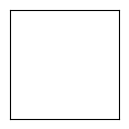

In [9]:
fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i].T))

#### c) Data Preparation

##### Rescale 
Rescales the images by dividing the pixel values by 255: [0,255] ⇒ [0,1]

In [10]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

##### One Hot Encode Target Labels
One-hot encoding is a process by which categorical variables are converted into a numeric form. One-hot encoding converts the (1 × n) label vector to a label matrix of dimensions (10 × n), where n is the number of sample images. So, if we have 1,000 images in our dataset, the label vector will have the dimensions (1 × 1000). After one-hot encoding, the label matrix dimensions will be (1000 × 10). That’s why, when we define our network architecture in the next step, we will make the output softmax layer contain 10 nodes, where each node represents the probability of each class we have.

In [11]:
num_classes = len(np.unique(y_train))
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

##### Split Data
Break original train set further into train and validation sets.

In [12]:
X_train, X_validation = X_train[500:], X_train[:500]
y_train, y_validation = y_train[500:], y_train[:500]

##### Save to Local

Create a local `data/cifar_10` directory to save the datasets.

In [13]:
DATASET_PATH = './data/cifar_10'

In [14]:
os.makedirs(DATASET_PATH, exist_ok=True)

Save train, validation and test sets to local `data` directory

In [15]:
np.save(f'{DATASET_PATH}/X_train.npy', X_train)
np.save(f'{DATASET_PATH}/y_train.npy', y_train)
np.save(f'{DATASET_PATH}/X_validation.npy', X_validation)
np.save(f'{DATASET_PATH}/y_validation.npy', y_validation)
np.save(f'{DATASET_PATH}/X_test.npy', X_test)
np.save(f'{DATASET_PATH}/y_test.npy', y_test)

##### Copy Datasets to S3
Copy train, validation and test sets from the local dir to S3, since SageMaker expects datasets to be in S3 for training.

In [16]:
!aws s3 cp ./{DATASET_PATH}/X_train.npy s3://{BUCKET}/{PREFIX}/cifar_10/train/
!aws s3 cp ./{DATASET_PATH}/y_train.npy s3://{BUCKET}/{PREFIX}/cifar_10/train/
!aws s3 cp ./{DATASET_PATH}/X_validation.npy s3://{BUCKET}/{PREFIX}/cifar_10/validation/
!aws s3 cp ./{DATASET_PATH}/y_validation.npy s3://{BUCKET}/{PREFIX}/cifar_10/validation/
!aws s3 cp ./{DATASET_PATH}/X_test.npy s3://{BUCKET}/{PREFIX}/cifar_10/test/
!aws s3 cp ./{DATASET_PATH}/y_test.npy s3://{BUCKET}/{PREFIX}/cifar_10/test/

upload: data/cifar_10/X_train.npy to s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/train/X_train.npy
upload: data/cifar_10/y_train.npy to s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/train/y_train.npy
upload: data/cifar_10/X_validation.npy to s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/validation/X_validation.npy
upload: data/cifar_10/y_validation.npy to s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/validation/y_validation.npy
upload: data/cifar_10/X_test.npy to s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/test/X_test.npy
upload: data/cifar_10/y_test.npy to s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/test/y_test.npy


#### d) Create Training Inputs 
Using the S3 locations of the datasets we saved in the previous step, create pointers to these datasets using the `TrainingInput`class from the SageMaker SDK.

In [17]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar_10/train', 
                            distribution='FullyReplicated', 
                            content_type='npy')
validation_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar_10/validation', 
                                 distribution='FullyReplicated', 
                                 content_type='npy')
test_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar_10/test', 
                           distribution='FullyReplicated', 
                           content_type='npy')

In [18]:
inputs = {'train': train_input, 'val': validation_input, 'test': test_input}

#### e) Define Model Architecture & create Training Script

We will build a small CNN consisting of three convolutional layers and two dense layers.<br>
<b>Note:</b> We will use the ReLU activation function for all the hidden layers. In the last dense layer, we will use a softmax activation function with 10 nodes to return an array of 10 probability scores (summing to 1). Each score will be the probability that the current image belongs to our 10 image classes.

In [19]:
!pygmentize cifar_train.py

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
import tensorflow as tf
import numpy as np
import argparse
import logging
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Seed for Reproducability 
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Setup Logger
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


def parse_args():
    parser = argparse.ArgumentParser() 
    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, default=os.environ.get('SM_CHANNEL

#### f) Create a TensorFlow Estimator & fit the Model

In [20]:
model_name = 'cifar-10'
hyperparameters = {'epochs': 30}
estimator_parameters = {'entry_point':'cifar_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'hyperparameters': hyperparameters,
                        'output_path': f's3://{BUCKET}/{PREFIX}/cifar_10/out',
                        'base_job_name': f'mme-cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}
estimator_1 = TensorFlow(**estimator_parameters)

In [21]:
estimator_1.fit(inputs)

[03/23/25 17:51:50] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=234381;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=72907;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=325596;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=155656;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=266041;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=981863;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             mme-cv-cifar-10-2025-03-23-17-51-50-756                                               

2025-03-23 17:51:52 Starting - Starting the training job...
2025-03-23 17:52:25 Downloading - Downloading input data...
2025-03-23 17:52:50 Downloading - Downloading the training image...
2025-03-23 17:53:06 Training - Training image download completed. Training in progress...2025-03-23 17:53:33,539 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2025-03-23 17:53:33,547 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 17:53:33,800 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 17:53:33,817 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 17:53:33,833 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 17:53:33,843 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        

### Train Model 2 - Sign Language Image Classification

#### a) Load Data

In [22]:
train_path  = './data/sign_language/train'
validation_path  = './data/sign_language/validation'
test_path  = './data/sign_language/test'

#### b) Data Exploration

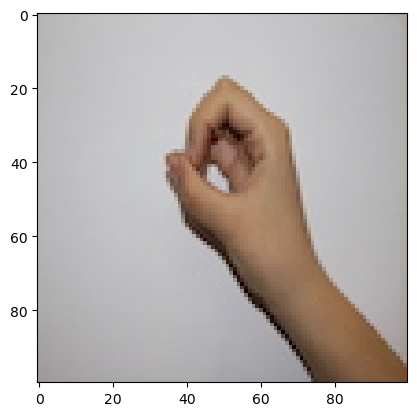

In [23]:
img = mpimg.imread(f'{train_path}/0/IMG_1118.JPG')
plt.imshow(img)

In [24]:
img.shape

(100, 100, 3)

<p>ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).

In [25]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224, 224), 
                                                         batch_size=10)

Found 1712 images belonging to 10 classes.


In [26]:
train_batches.next()[0][0].shape

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 train_batches.next()[0][0].shape                                                             │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DirectoryIterator' object has no attribute 'next'

Visualize random sample of images from `train_batches`

In [27]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(224, 224))
for row in rows:
    row.imshow(train_batches.next()[0][0].astype('int').T)
    row.axis('off')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(224, 224))                               │
│   2 for row in rows:                                                                             │
│ ❱ 3 │   row.imshow(train_batches.next()[0][0].astype('int').T)                                   │
│   4 │   row.axis('off')                                                                          │
│   5 plt.show()                                                                                   │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DirectoryIterator' object has no attribute 'next'

#### c) Copy local data to S3 for SageMaker training

In [28]:
!aws s3 cp ./data/sign_language/ s3://{BUCKET}/{PREFIX}/sign_language/ --recursive

upload: data/sign_language/test/0/IMG_5695.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/0/IMG_5695.JPG
upload: data/sign_language/test/0/IMG_4725.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/0/IMG_4725.JPG
upload: data/sign_language/test/0/IMG_4159.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/0/IMG_4159.JPG
upload: data/sign_language/test/0/IMG_4976.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/0/IMG_4976.JPG
upload: data/sign_language/test/0/IMG_5572.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/0/IMG_5572.JPG
upload: data/sign_language/test/1/IMG_4497.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/1/IMG_4497.JPG
upload: data/sign_language/test/1/IMG_5340.JPG to s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/test/1/IMG_5340.JPG
upload: data/sign_language/test/1/IMG_5992.JPG to s3://sagemaker-us-west-2-9

#### d) Define Model Architecture & create Training Script

In [29]:
!pygmentize sign_language_train.py

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import argparse
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)


def parse_args():
    parser = argparse.ArgumentParser() 
    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, defau

#### f) Create a TensorFlow Estimator & fit the Model

In [30]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_language/train', 
                            distribution='ShardedByS3Key')
val_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_language/validation', 
                          distribution='ShardedByS3Key')

In [31]:
model_name = 'sign-language'

hyperparameters = {'epochs': 1}
estimator_parameters = {'entry_point':'sign_language_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'hyperparameters': hyperparameters,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'output_path': f's3://{BUCKET}/{PREFIX}/sign_language/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}

estimator_2 = TensorFlow(**estimator_parameters)

In [32]:
estimator_2.fit({'train': train_input, 'val': val_input})

[03/23/25 18:27:30] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=989910;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=378239;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=181438;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=757336;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=400270;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=749107;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             cv-sign-language-2025-03-23-18-27-30-172                                              

2025-03-23 18:27:31 Starting - Starting the training job...
2025-03-23 18:28:04 Downloading - Downloading input data...
2025-03-23 18:28:24 Downloading - Downloading the training image...
2025-03-23 18:28:44 Training - Training image download completed. Training in progress...2025-03-23 18:29:09,543 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2025-03-23 18:29:09,551 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 18:29:09,810 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 18:29:09,826 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 18:29:09,842 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-23 18:29:09,853 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        

### Create a Multi-Model Endpoint

#### a) Copy Trained Models to a common S3 Prefix

In [33]:
tf_model_1 = estimator_1.model_data
output_1 = f's3://{BUCKET}/{PREFIX}/mme/cifar.tar.gz'

In [34]:
tf_model_2 = estimator_2.model_data
output_2 = f's3://{BUCKET}/{PREFIX}/mme/sign-language.tar.gz'

In [35]:
tf_model_2

's3://sagemaker-us-west-2-986030204467/cv-models/sign_language/out/cv-sign-language-2025-03-23-18-27-30-172/output/model.tar.gz'

In [36]:
!aws s3 cp {tf_model_1} {output_1}
!aws s3 cp {tf_model_2} {output_2}

copy: s3://sagemaker-us-west-2-986030204467/cv-models/cifar_10/out/mme-cv-cifar-10-2025-03-23-17-51-50-756/output/model.tar.gz to s3://sagemaker-us-west-2-986030204467/cv-models/mme/cifar.tar.gz
copy failed: s3://sagemaker-us-west-2-986030204467/cv-models/sign_language/out/cv-sign-language-2025-03-23-18-27-30-172/output/model.tar.gz to s3://sagemaker-us-west-2-986030204467/cv-models/mme/sign-language.tar.gz An error occurred (AccessDenied) when calling the GetObjectTagging operation: User: arn:aws:sts::986030204467:assumed-role/SageMaker-ExecutionRole-20250204T184611/SageMaker is not authorized to perform: s3:GetObjectTagging on resource: "arn:aws:s3:::sagemaker-us-west-2-986030204467/cv-models/sign_language/out/cv-sign-language-2025-03-23-18-27-30-172/output/model.tar.gz" because no identity-based policy allows the s3:GetObjectTagging action


#### b) Essentials

In [37]:
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

'2025-03-23-18-30-19'

In [38]:
IMAGE_URI = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04'
model_data_prefix = f's3://{BUCKET}/{PREFIX}/mme/'

#### c) Create a MultiDataModel using Model 1 

In [39]:
model_1 = TensorFlowModel(model_data=output_1, 
                          role=role, 
                          image_uri=IMAGE_URI)

In [40]:
mme = MultiDataModel(name=f'mme-tensorflow-{current_time}',
                     model_data_prefix=model_data_prefix,
                     model=model_1,
                     sagemaker_session=sagemaker_session)

#### d) Deploy Multi-Model Endpoint

In [41]:
predictor = mme.deploy(initial_instance_count=1,
                       instance_type='ml.m5.2xlarge',
                       endpoint_name=f'mme-tensorflow-{current_time}')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictor = mme.deploy(initial_instance_count=1,                                             │
│   2 │   │   │   │   │      instance_type='ml.m5.2xlarge',                                        │
│   3 │   │   │   │   │      endpoint_name=f'mme-tensorflow-{current_time}')                       │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/multidatamodel.py:252 in deploy                │
│                                                                                                  │
│   249 │   │                                                                                      │
│   250 │   │   tags = format_tags(tags)                                                           │
│   251 │   │                                                                                      │
│ ❱ 252 │   │   container_def = self.prepare_container_def(instance_type, accelerator_type=accel   │
│   253 │   │   self.sagemaker_session.create_model(                                               │
│   254 │   │   │   self.name,                                                                     │
│   255 │   │   │   role,                                                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/multidatamodel.py:146 in prepare_container_def │
│                                                                                                  │
│   143 │   │   # with FrameworkEstimator set framework specific environment variables which nee   │
│   144 │   │   # copied over                                                                      │
│   145 │   │   if self.model:                                                                     │
│ ❱ 146 │   │   │   container_definition = self.model.prepare_container_def(instance_type, accel   │
│   147 │   │   │   image_uri = container_definition["Image"]                                      │
│   148 │   │   │   environment = container_definition["Environment"]                              │
│   149 │   │   else:                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/model.py:434 in                     │
│ prepare_container_def                                                                            │
│                                                                                                  │
│   431 │   │   )                                                                                  │
│   432 │   │   env = self._get_container_env()                                                    │
│   433 │   │                                                                                      │
│ ❱ 434 │   │   bucket, key_prefix = s3.determine_bucket_and_prefix(                               │
│   435 │   │   │   bucket=self.bucket,                                                            │
│   436 │   │   │   key_prefix=sagemaker.fw_utils.model_code_key_prefix(                           │
│   437 │   │   │   │   self.key_prefix, self.name, image_uri                                      │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/s3_utils.

In [ ]:
list(mme.list_models())

### Test Multi-Model Endpoint for Real Time Inference 

#### a) Test Model-1 CIFAR Image Classification

In [42]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np

In [43]:
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

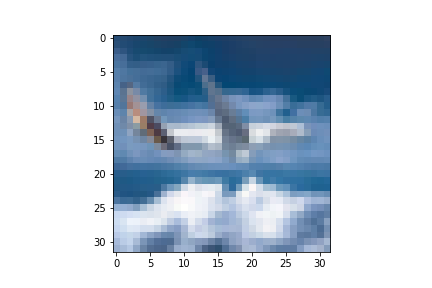

In [44]:
Image('./data/cifar_10/raw_images/airplane.png')

In [45]:
img = load_img('./data/cifar_10/raw_images/airplane.png', target_size=(32, 32))
data = img_to_array(img)
data = data.astype('float32')
data = data / 255.0
data = data.reshape(1, 32, 32, 3)

In [46]:
payload = {'instances': data}

In [47]:
payload

{'instances': array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]],

In [ ]:
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'cifar.tar.gz'})

In [ ]:
predicted_label = CIFAR10_LABELS[np.argmax(y_pred)]
print(f'Predicted Label: [{predicted_label}]')

#### b) Test Model-2 Sign Language Classification

In [ ]:
test_path  = './data/sign_language/test'
img = mpimg.imread(f'{test_path}/0/IMG_4159.JPG')
plt.imshow(img)

In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [ ]:
data = path_to_tensor(f'{test_path}/0/IMG_4159.JPG')
payload = {'instances': data}

In [ ]:
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'sign-language.tar.gz'})

In [ ]:
predicted_label = np.argmax(y_pred)
print(f'Predicted Label: [{predicted_label}]')